This notebooks plots some descriptive statistics of the raw text data.


## Inputs

- `data/pubmed/abstracts_2023.csv.gz`: raw text data

In [1]:
%reload_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import seaborn as sns
from src.cogtext.datasets.pubmed import PubMedDataset
from wordcloud import WordCloud

import polars as pl

sns.set('notebook')

In [2]:
data = PubMedDataset(year=2023).load()

# keep only journals with >1000 abstracts or relevant title
data = PubMedDataset.select_relevant_journals(data)

# keep only abstracts with >10 words
data = PubMedDataset.remove_short_abstracts(data, min_words=10)

# report stats
n_articles = len(data)
n_unique_articles = data.unique('pmid').shape[0]
abstract_words_median = data['abstract'].str.split(' ').map_elements(lambda x: len(x)).median()

print(f'Dataset contains {n_articles} relevant articles, of which {n_unique_articles} are unique.')
print(f'Median number of words per abstract: {abstract_words_median:.0f}.')

Dataset contains 413438 relevant articles, of which 283383 are unique.
Median number of words per abstract: 228.


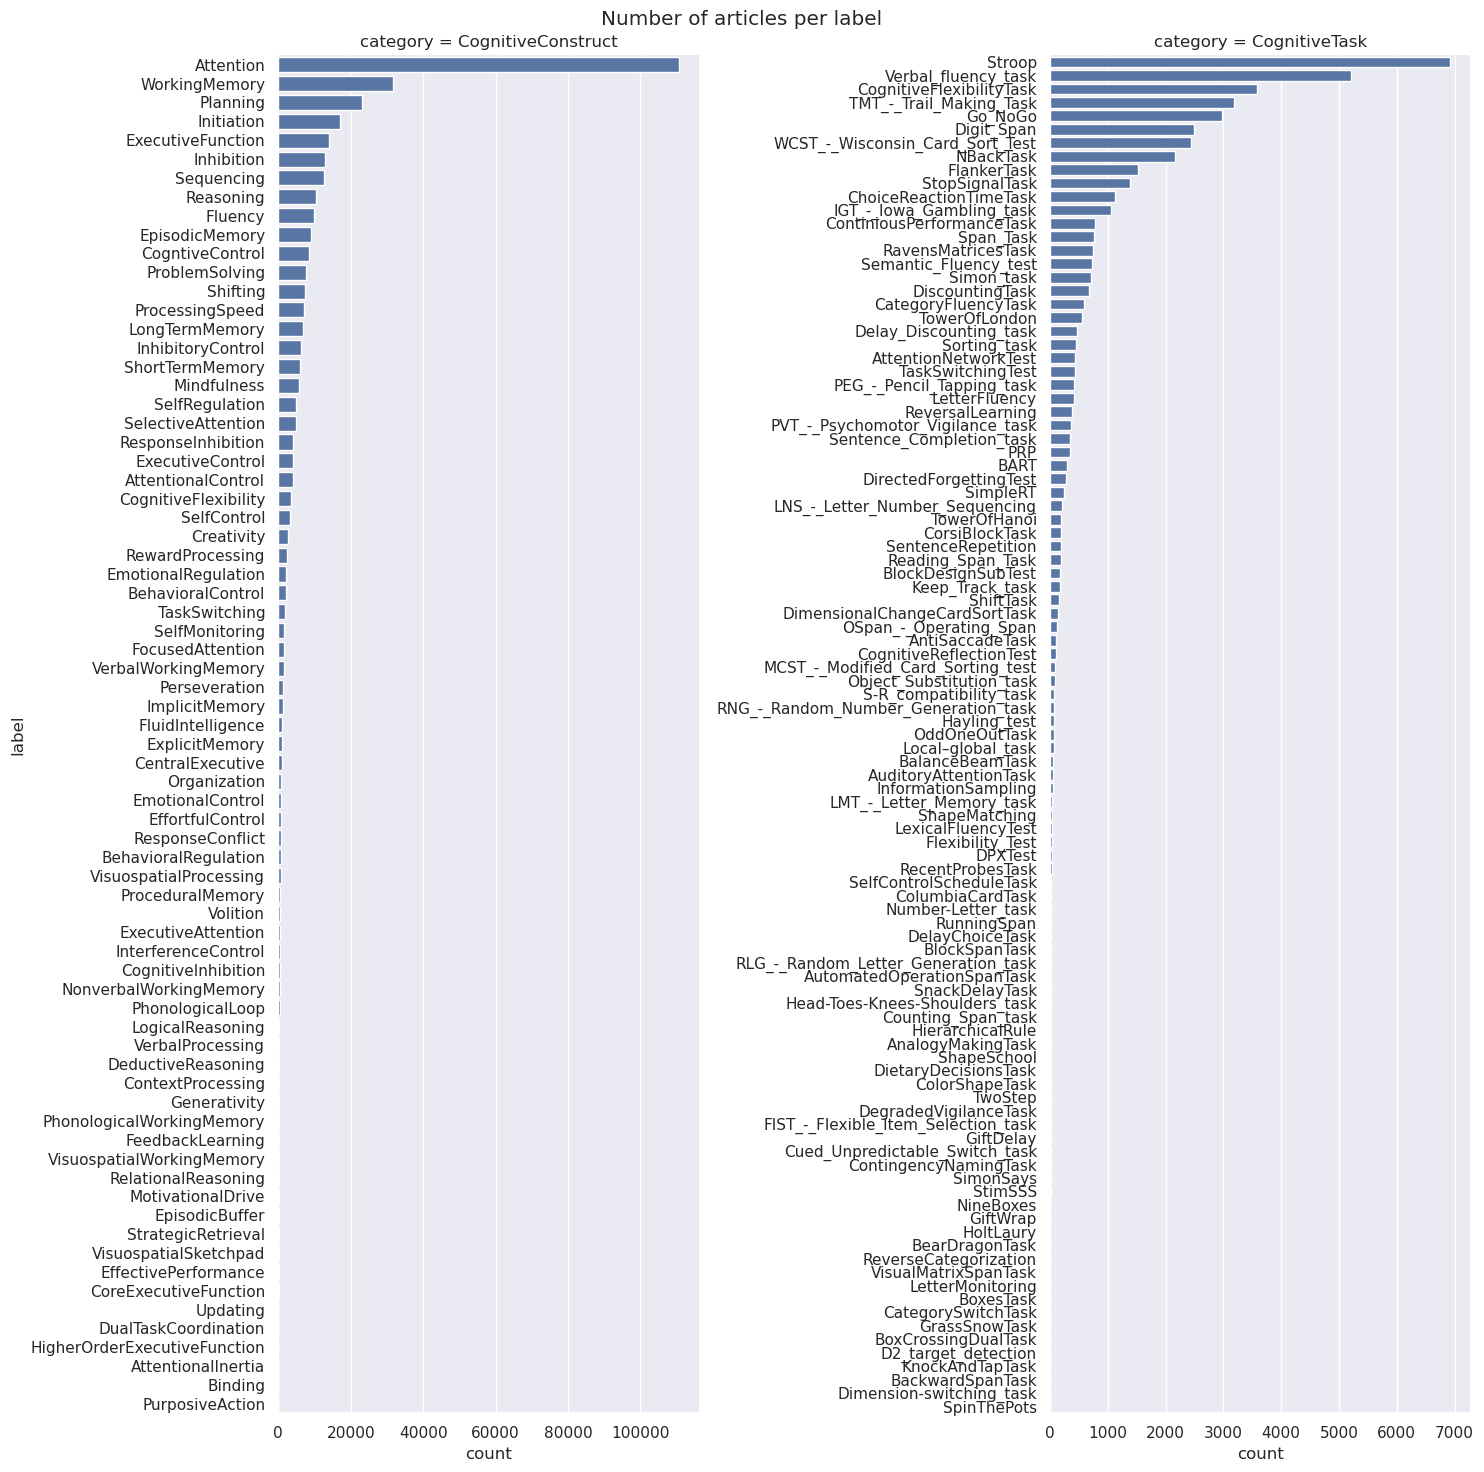

In [4]:
# plot number of articles for each lexicon term (or labels).

plot_data = (data.group_by(['category', 'label'])
                 .n_unique()
                 .sort(by='pmid', descending=True)[['category','label','pmid']]
                 .rename({'pmid': 'count'})
                 .to_pandas())

sns.catplot(data=plot_data, x='count', y='label', col='category',
            orient='h', kind='bar', height=15, aspect=0.5,
            sharex=False, sharey=False)

plt.suptitle('Number of articles per label')
plt.tight_layout()
plt.show()

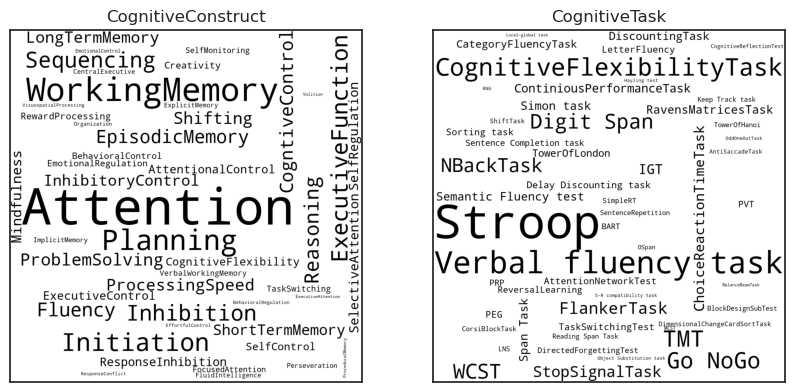

In [5]:
# wordclouds

def get_frequency(data: pl.DataFrame):

    categories = data.get_column('category').unique().to_list()

    frequencies = {}  # key: category, value: dict of label frequencies

    for c in categories:
        labels_freq = data.filter(pl.col('category') == c).group_by('label').count().to_dicts()
        frequencies[c] = {f['label'].replace('_', ' ').split(' - ', 1)[0]:f['count']
                          for f in labels_freq}

    return frequencies

frequencies = get_frequency(data)

sns.set_theme(style='ticks')
fig, axes = plt.subplots(1, len(frequencies), figsize=(10, 5))

for i, (category, freq) in enumerate(frequencies.items()):
    wc = WordCloud(background_color="white", max_words=200, width=1000, height=1000,
                   min_font_size=12, relative_scaling=0.5,
                   color_func=lambda *args, **kwargs: 'black')
    wc.generate_from_frequencies(freq)
    axes[i].imshow(wc)
    axes[i].set_title(category)
    # hide ticks
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.savefig(f'outputs/descriptive_plots/word_cloud.png', dpi=300, bbox_inches='tight')

In [6]:
# get min and max year of appearances
appearances = data.group_by(['category', 'label']).agg(
    pl.col('year').min().alias('first_appearance'),
    pl.col('year').max().alias('last_appearance'))
appearances.sort(by='first_appearance', descending=True)

category,label,first_appearance,last_appearance
str,str,i64,i64
"""CognitiveTask""","""SpinThePots""",2021,2021
"""CognitiveTask""","""StimSSS""",2016,2021
"""CognitiveTask""","""DietaryDecisio…",2016,2023
"""CognitiveTask""","""BoxesTask""",2014,2020
"""CognitiveTask""","""CategorySwitch…",2013,2023
"""CognitiveTask""","""SnackDelayTask…",2012,2023
"""CognitiveTask""","""GrassSnowTask""",2012,2017
"""CognitiveTask""","""D2_target_dete…",2011,2020
"""CognitiveTask""","""ReverseCategor…",2010,2022


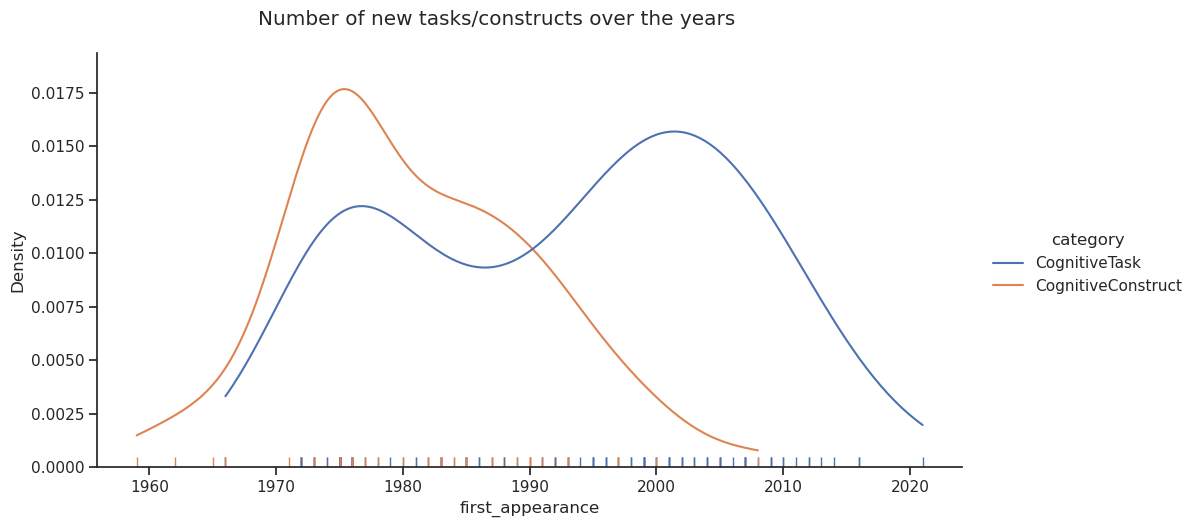

In [7]:
# plot first appearance of task/construct as a function of time

sns.displot(
  x='first_appearance',
  data=appearances,
  hue='category',
  kind='kde', cut=0, rug=True,
  height=5, aspect=2)

plt.suptitle('Number of new tasks/constructs over the years', y=1.05, x=.42)
# ax.legend_.set_title(None)
plt.show()